In [71]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import os
from IPython import display

In [ ]:
# Required for Jupyter Notebook to find the graphviz executables
os.environ["PATH"] += os.pathsep + os.path.abspath("/opt/homebrew/bin/")

In [ ]:
# Sample function for gradient calculation
def f(x):
    return 3*x**2 - 4*x + 5

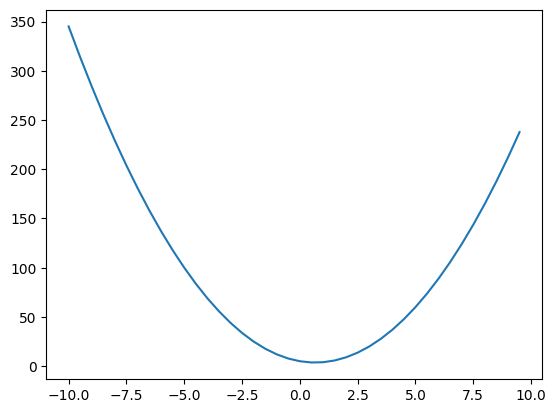

In [54]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [123]:
h = 0.000001

In [124]:
a = 3
b = -2
c = 1
d1 = a*b + c

In [125]:
c = c + h
d2 = a*b + c

In [126]:
print("d1 = ", d1)
print("d2 = ", d2)
print("dc_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dc_dy =  1.000000000139778


In [127]:
a = 3; b = -2; c = 1
d1 = a*b + c
a = a + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("da_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -5.000002
da_dy =  -2.000000000279556


In [128]:
a = 3; b = -2; c = 1
d1 = a*b + c
b = b + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("db_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.9999970000000005
db_dy =  2.9999999995311555


In [130]:
a = 3; b = -2; c = 1
d1 = a*b + c
d2 = a*b + h + c
print("d1 = ", d1)
print("d2 = ", d2)
print("dab_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dab_dy =  1.000000000139778


In [ ]:
class Value():
    """ Basic class to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, _children=(self, other), _op='+')
        else:
            raise ValueError("Can only add Value to Value")
    
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [132]:
a = Value(3, label="a")
b = Value(-2, label="b")
c = Value(1, label="c")
d = a*b + c; d.label = "d"
print(f"d._prev = {d._prev} d = {d.data}")

d._prev = (Value(data=-6), Value(data=1)) d = -5


In [133]:
def draw_graph(root):
    """ Vibe codded and it works! """
    # Initialize a directed graph
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # Left-to-right layout
    
    def build_graph(node, visited=None):
        if visited is None:
            visited = set()
        
        # Skip if node already visited to avoid cycles
        if id(node) in visited:
            return
        visited.add(id(node))
        
        # Add node to the graph
        node_id = str(id(node))
        dot.node(node_id, f"{{ {node.label} | data = {node.data} grad={node.grad} }}", shape='record')
        
        # If node has an operation, create an operation node
        if node._op:
            op_id = f"{node_id}_op"
            dot.node(op_id, node._op, shape='circle')
            dot.edge(op_id, node_id)  # Edge from operation to result
        
            # Recursively process children
            for child in node._prev:
                child_id = str(id(child))
                build_graph(child, visited)
                dot.edge(child_id, op_id)  # Edge from child to operation
    
    # Build the graph starting from the root
    build_graph(root)
    
    # Render and display the graph
    dot.render('computation_graph', view=True, cleanup=True)
    
    return dot


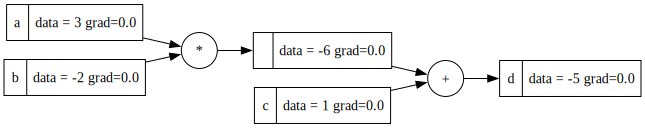

In [134]:
draw_graph(d)

In [145]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [136]:
print(f"o = {o.data}")

o = -0.9866142981514304


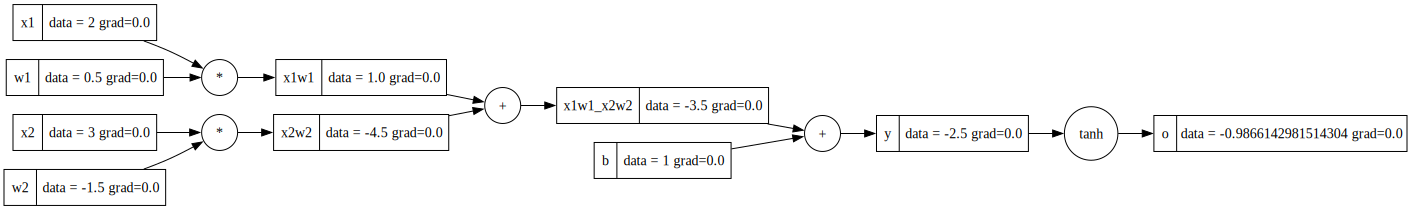

In [115]:
draw_graph(o)

In [137]:
# Backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

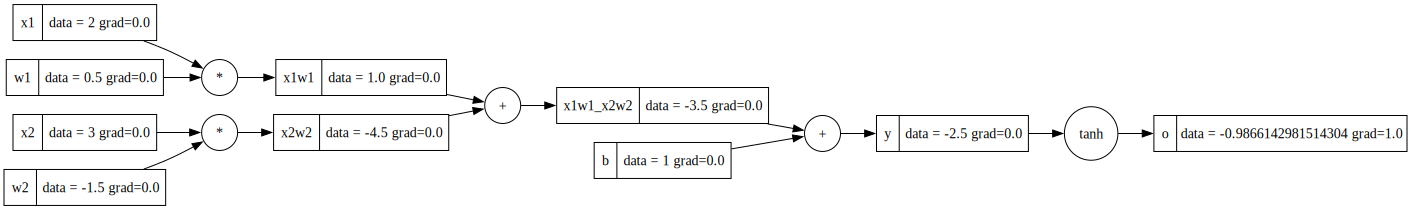

In [117]:
draw_graph(o)

In [138]:
do_dn = 1 - math.tanh(o.data)**2
y.grad = do_dn

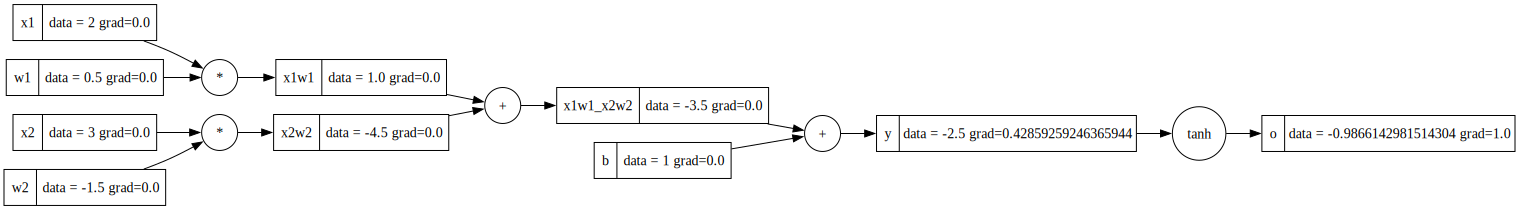

In [119]:
draw_graph(o)

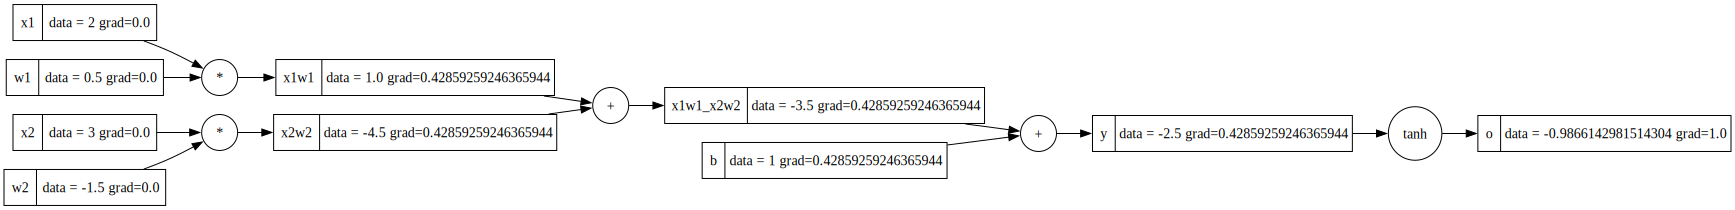

In [140]:
x1w1_x2w2.grad = y.grad
b.grad = y.grad
x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

draw_graph(o)

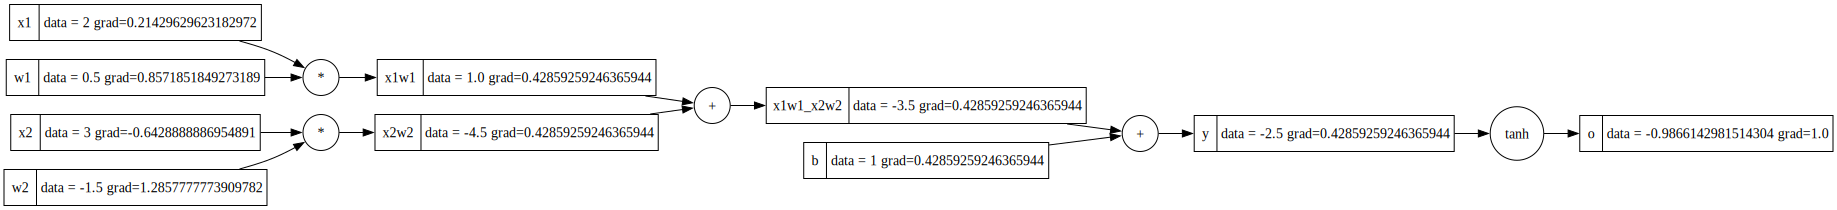

In [142]:
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

draw_graph(o)

In [230]:
# Implement generic backpropagation
class Value():
    """ Complete class with backprop to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero

    def backward(self, root_node, visited=None):
        visited.add(self)
        print(f"node.data = {self.data}")
        self._backward()  # Compute the gradient for childeren of this node
        for item in self._prev:
            if item not in visited:
                item.backward(root_node, visited)

    def _backward(self):
        """ Perform backpropagation to compute gradients. """
        print(f"Backward pass for node: {self.label}, op: {self._op}, data: {self.data}, grad: {self.grad}")
        # For addition operation, local gradient is 1 for each child hence gradient of the child with respect
        # to the output is 1 * self gradient.
        # Note, we need to accumulate gradients for each child and not simply overwrite them.
        if self._op == '+':
            for child in self._prev:
                child.grad += self.grad

        # For multiplication operation, local gradient is the value of the other child hence
        # gradient of the child with respect to the output is self.grad * other child's value.
        elif self._op == '*':
            self._prev[0].grad = self.grad * self._prev[1].data
            self._prev[1].grad = self.grad * self._prev[0].data

        # For tanh operation, local gradient is 1 - tanh^2(self.data) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == 'tanh':
            print(f"tanh: self.data = {self.data}, self.grad = {self.grad}")
            self._prev[0].grad = self.grad * (1 - np.tanh(self._prev[0].data)**2)

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, _children=(self, other), _op='+')
        else:
            raise ValueError("Can only add Value to Value")
    
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [231]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

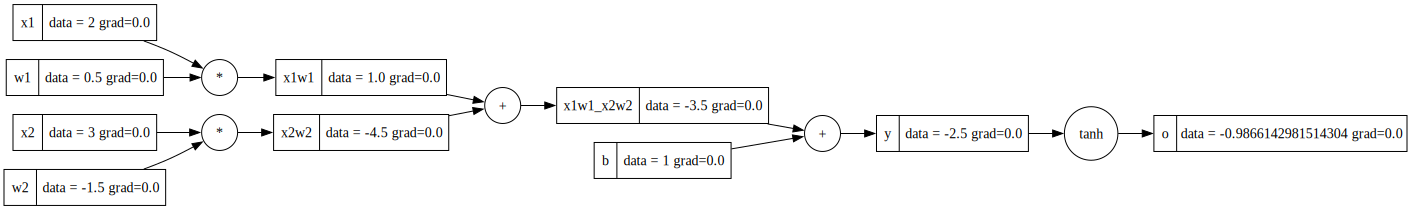

In [232]:
draw_graph(o)

In [233]:
# Perform backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

visited = set()
o.backward(o, visited)

node.data = -0.9866142981514304
Backward pass for node: o, op: tanh, data: -0.9866142981514304, grad: 1.0
tanh: self.data = -0.9866142981514304, self.grad = 1.0
node.data = -2.5
Backward pass for node: y, op: +, data: -2.5, grad: 0.026592226683160525
node.data = -3.5
Backward pass for node: x1w1_x2w2, op: +, data: -3.5, grad: 0.026592226683160525
node.data = 1.0
Backward pass for node: x1w1, op: *, data: 1.0, grad: 0.026592226683160525
node.data = 2
Backward pass for node: x1, op: , data: 2, grad: 0.013296113341580262
node.data = 0.5
Backward pass for node: w1, op: , data: 0.5, grad: 0.05318445336632105
node.data = -4.5
Backward pass for node: x2w2, op: *, data: -4.5, grad: 0.026592226683160525
node.data = 3
Backward pass for node: x2, op: , data: 3, grad: -0.03988834002474079
node.data = -1.5
Backward pass for node: w2, op: , data: -1.5, grad: 0.07977668004948157
node.data = 1
Backward pass for node: b, op: , data: 1, grad: 0.026592226683160525


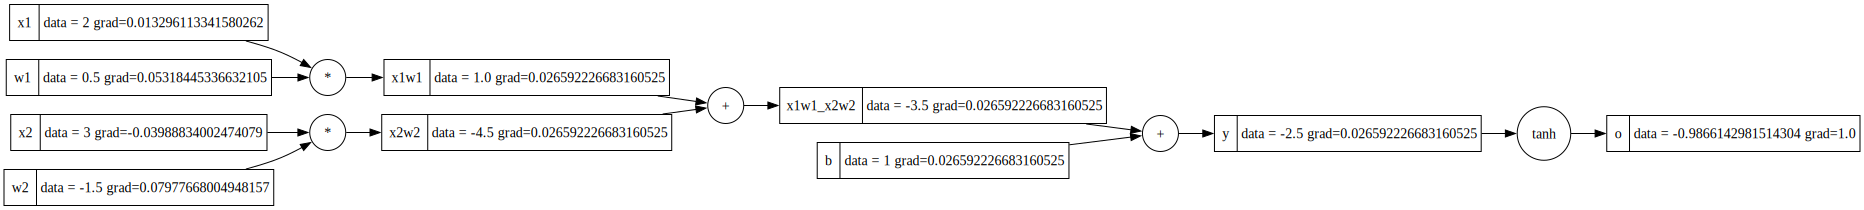

In [234]:
draw_graph(o)

In [229]:
# Verfiy with PyTorch
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

import torch

x1 = torch.Tensor([2.0])
x2 = torch.Tensor([3.0])
w1 = torch.Tensor([0.5])
w2 = torch.Tensor([-1.5])
b = torch.Tensor([1.0])
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

y = x1 * w1 + x2 * w2 + b
o = torch.tanh(y)

print(f"o = {o.item()}")

o.backward()  # Perform backpropagation

o = -0.9866142868995667


In [228]:
print(f"x1.grad = {x1.grad.item()}") 
print(f"x2.grad = {x2.grad.item()}") 
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"b.grad = {b.grad.item()}")

x1.grad = 0.013296124525368214
x2.grad = -0.039888374507427216
w1.grad = 0.053184498101472855
w2.grad = 0.07977674901485443
b.grad = 0.026592249050736427
